# Проект: прогноз оттока клиентов

## Введение  

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами. На основе аналитических данных, которые содержат данные на месяц до оттока и факт оттока на определённый месяц менеджеры хотят спрогнозировать отток клиентов.  

**Цель:** провести анализ, научиться прогнозировать вероятность оттока, подготовить план действий по удержанию клиентов.  

Исследование проводится в 5 этапов:  

1. Обзор данных  
2. Предобработка данных  
3. Исследовательский анализ данных  
4. Модель прогнозирования оттока клиентов  
5. Кластеризация клиентов

## Обзор данных  

Ознакомимся с входными данными.  

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools

In [2]:
# игнорируем предупреждения

import warnings

warnings.filterwarnings('ignore') 

In [3]:
# снимем ограничения на вывод строк и столбцов

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# прочитаем файл с данными и сохраним его в переменную

data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
# получим общую информацию о таблице
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**В наличии следующие данные:**  

Данные клиента за предыдущий до проверки факта оттока месяц:  
- 'gender' — пол;  
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
- 'Partner' — сотрудник компании-партнёра клуба;  
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
- 'Phone' — наличие контактного телефона;  
- 'Age' — возраст;  
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).   

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — средняя суммарная выручка за месяц от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце: 0 - те, кто остался, 1 - те, кто ушел

### Выводы:  

В таблице 13 столбцов, названия столбцов нужно привести к нижнему регистру. В каждой строке таблицы — данные о клиенте и о его посещениях фитнес-клуба.  

Пропусков значений нет. Типы данных корректны.

## Предобработка данных  

- Приведем написание названий столбцов к единому стилю

In [6]:
# приведем названия столбцов к нижнему регистру и выведем названия для проверки

data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

- Проверим наличие дубликатов

In [7]:
# найдем сумму явных дубликатов в таблицах

data.duplicated().sum()

0

### Вывод:  

Дубликатов нет. Названия столбцов привели к единому написанию.

## Исследовательский анализ данных  

- **Оценим статистические показатели по всей таблице** 

In [8]:
# транспонируем таблицу и оценим статистические показатели 

data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- **Оценим статистические показатели в группах: для тех, кто ушел в отток и тех, кто остался** 

In [9]:
# создадим список названий столбцов без последнего столбца 'churn' 

new_columns = data.columns[:-1]
new_columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month'],
      dtype='object')

In [10]:
#код ревьюера
data.groupby('churn').mean().transpose()

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [11]:
# создадим сгруппированную таблицу по оттоку, посчитаем среднее для всех признаков
# транспонируем таблицу

data_churn = data.groupby('churn')[new_columns].mean().transpose()
data_churn

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


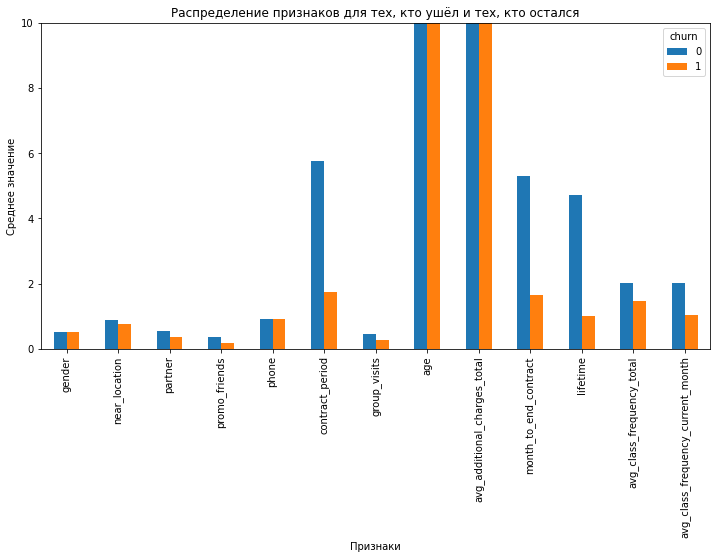

In [12]:
# построим гистограмму для признаков по группам

data_churn.plot(kind='bar',figsize=(12, 6), ylim=(0,10))
plt.title('Распределение признаков для тех, кто ушёл и тех, кто остался')
plt.xlabel('Признаки')
plt.ylabel('Среднее значение');

- **Построим матрицу корреляции**

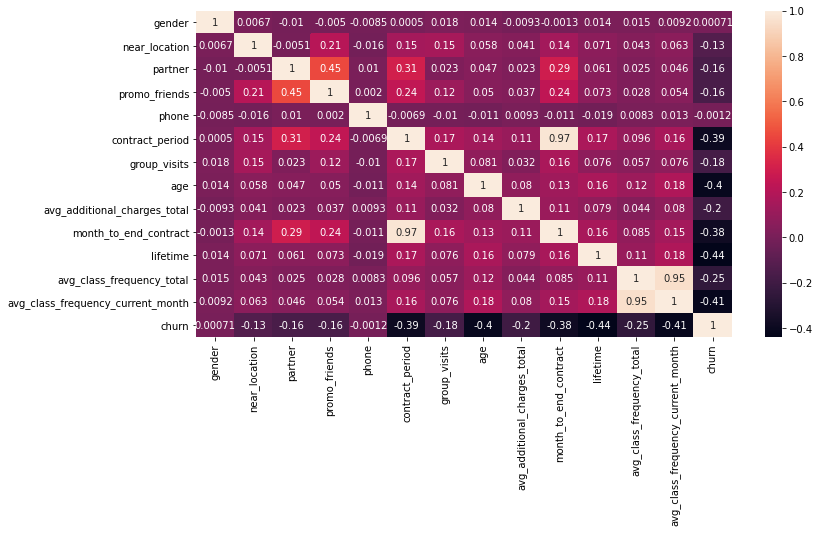

In [13]:
# построим хитмэп корреляции между признаками

corr = data.corr()
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

### Вывод:  

**После анализа общей таблицы получаем, что:**  
- мужчин и женщин равное количество  
- 85% посетителей фитнес-клуба живут или работают в районе фитнес-клуба   
- 49% являются сотрудниками компаний-партнеров  
- 31% использовали промокод от знакомого  
- 90% посетителей оставляют свой номер телефона  
- в среднем длительность абонемента составляет 5 месяцев  
- 41% посещают групповые занятия  
- средний возраст посетителя 29 лет
- среднемесячная выручка от других услуг составляет 147, медианное значение сильно не отличается, следовательно в таблице нет аномально низких или высоких значений   
- в среднем до конца абонемента у пользователей осталось 4 месяца, а лайфтайм составляет 3 месяца  
- среднее количество посещений в неделю за все время и за предыдущий месяц практически одинаковы - 1,8  
- средний отток 27%  

**Для тех, кто продолжил заниматься в сравнении с теми, кто ушел, характерно:**
- на 10% больше тех, кто живет или работает рядом с фитнес-центром  
- почти 54% являются сотрудниками компаний-партнеров, против 36%  
- в два раза больше посетителей воспользовались промокодом от знакомого  
- длительность абонимента в 3 раза больше, в среднем около 6 мес  
- в 2 раза чаще посещают групповые занятия   
- в среднем на 3 года старше  
- больше тратят на дополнительные услуги  
- средняя частота посещений почти в 2 раза больше  

Наибольшая корреляция между признаками 'month_to_end_contract' - 'contract_period' и 'avg_class_frequency_total' - 'avg_class_frequency_current_month'. Они являются очень близкими показателями, поэтому никакой зависимости не показывают.  

Зависимость видна между тем, что клиент является сотрудником компании-партнера и тем, что он воспользовался промокодом от знакомого - коэффициент корреляции 0,45.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.  

- **Разобьем данные на обучающую и валидационную выборку**

In [14]:
# X - признаки
X = data.drop(['churn'], axis=1)

# y - целевая переменная
y = data['churn']

# разобьем модель на обучающую и валидационную выборку в соотношении 80 на 20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# стандартизируем данные
scaler = StandardScaler()

# обучим scaler на обучающей выборке
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

- **Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.**  

   - *Логистическая регрессия*

In [15]:
# зададим алгоритм для модели
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)

# оценим вероятность принадлежности к классу 1 для объектов из валидационного набора данных 
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

# выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


   - *Случайный лес*

In [16]:
# зададим алгоритм для модели
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)

# оценим вероятность принадлежности к классу 1 для объектов из валидационного набора данных
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81


In [17]:
# зададим порог
threshold = 0.4

# на основании вероятностей и соотношения классов рассчитаем predict
lr_custom_predictions = [0 if i < threshold else 1 for i in lr_probabilities]
rf_custom_predictions = [0 if i < threshold else 1 for i in rf_probabilities]

# выведем все изученные метрики для прогноза по новому порогу
print('Метрики для прогноза с кастомным порогом:')
print()
print('Для логистической регрессии')
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, lr_custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, lr_custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, lr_custom_predictions)))
print()
print('Для случайного леса')
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, rf_custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, rf_custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, rf_custom_predictions)))

Метрики для прогноза с кастомным порогом:

Для логистической регрессии
Accuracy for custom: 0.92
Precision for custom: 0.82
Recall for custom: 0.86

Для случайного леса
Accuracy for custom: 0.92
Precision for custom: 0.81
Recall for custom: 0.88


### Вывод:  

Доля правильных ответов для обеих моделей одинаковая и составляет 0,92.  
Доля правильных ответов среди целевого класса для модели случайного леса выше на 0,01.  
Полнота правильных ответов выше у логистической регрессии на 0,02.  

Для того, чтобы увеличить полноту правильных ответов сместим порог "уверенности".  
После смещения порога до 0,4, метрика Recall выросла в обеих моделях. Но больше всего в модели случайного леса и составила 0,88.   
На остальные метрики сдвиг порога повлиял незначительно.  

Следовательно, модель случайного леса показала себя лучше в прогнозировании.

## Кластеризация клиентов  

Приведем признаки к единому масштабу. Будем применять эти данные для дальнейшего обучения и прогнозирования.  

- Построим матрицу расстояний и выделим кластеры

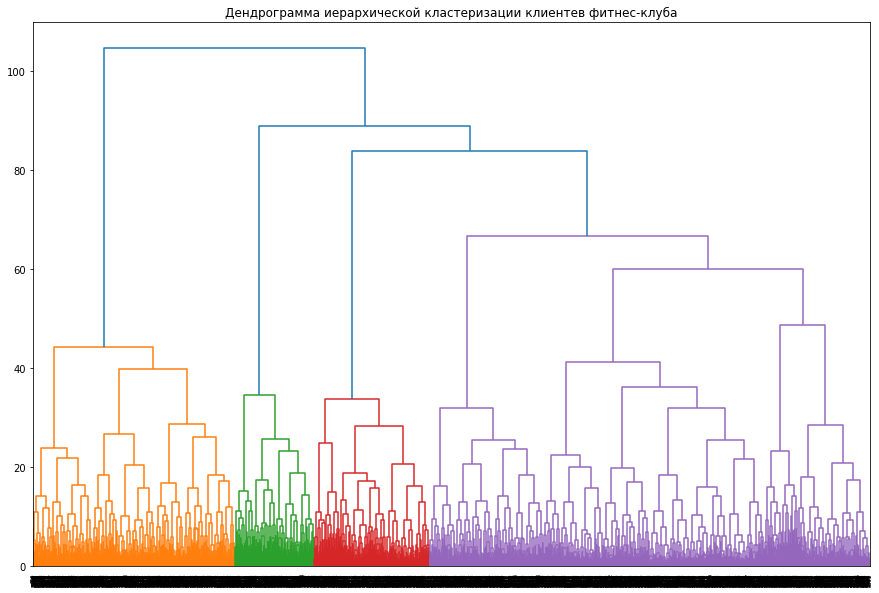

In [18]:
# обучим нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(data.drop(columns = ['churn'])) 

# строим дендрограмму 
plt.figure(figsize=(15,10))
linked = linkage(x_sc, method='ward')
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентев фитнес-клуба')
plt.show()

- Сгруппируем клиентов с помощью алгоритма K-Means и выведем средние значения по признакам для каждого кластера.  
  Построим диаграмму распределения признаков по кластерам.

In [19]:
# зададим число кластеров, равное 5
km = KMeans(n_clusters=5, random_state=0) 

# применим алгоритм к данным и сформируем вектор кластеров 
labels = km.fit_predict(x_sc) 

# сохраним метки кластера в отдельном столбце таблицы
data['cluster'] = labels

# выведем статистику по средним значениям признаков по кластеру и транспонируем таблицу
clusters = data.groupby(['cluster']).mean().transpose()
clusters.columns = ['1', '2', '3', '4', '5']
clusters

,1,2,3,4,5
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


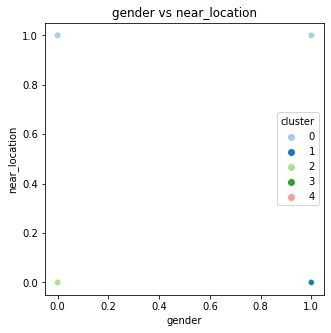

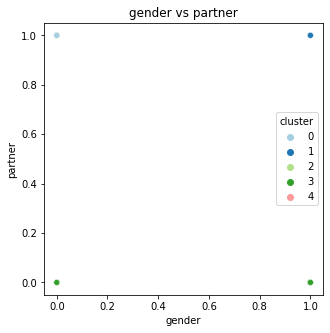

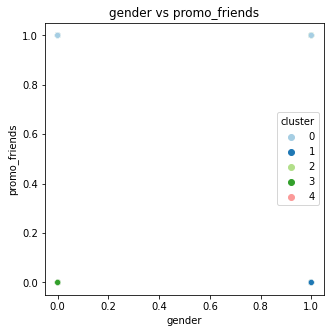

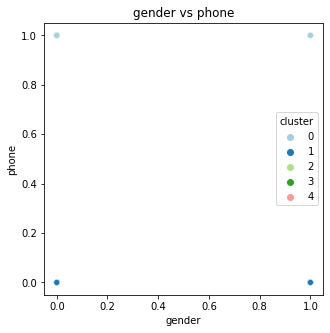

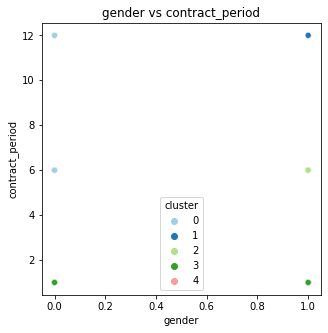

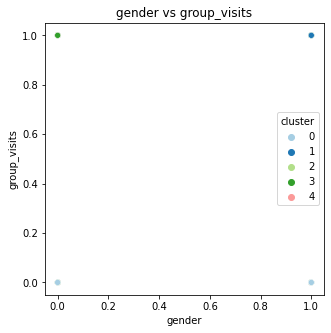

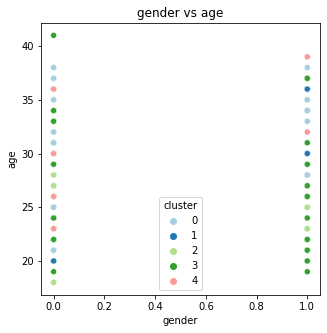

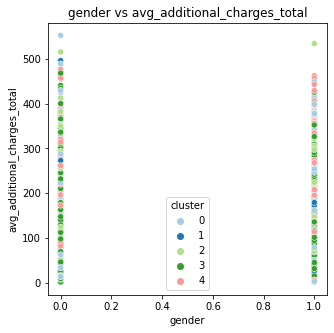

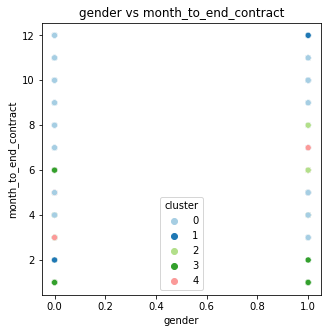

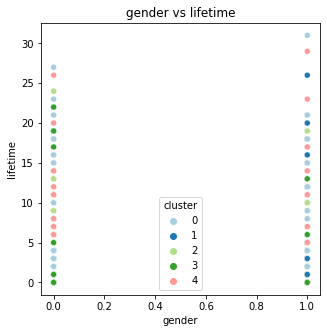

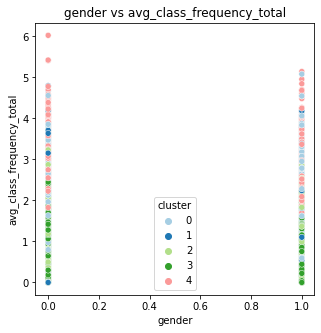

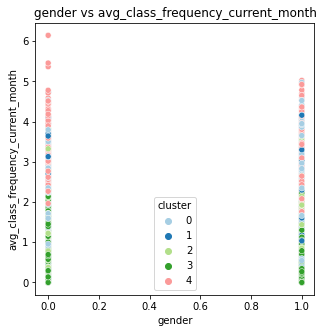

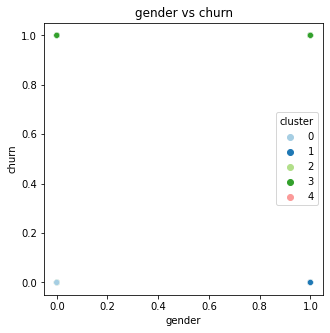

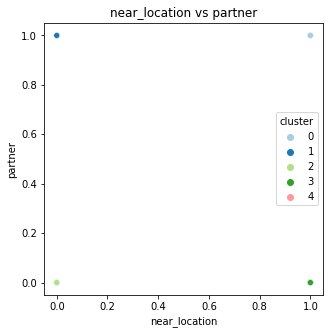

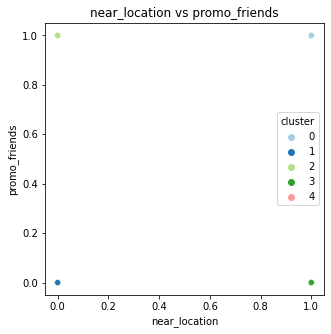

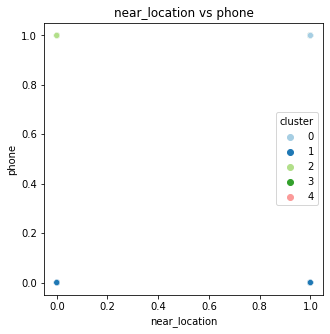

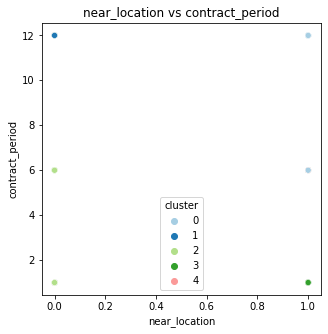

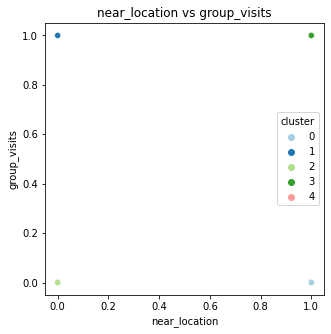

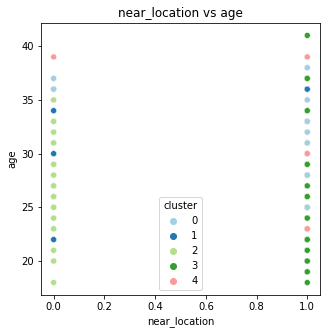

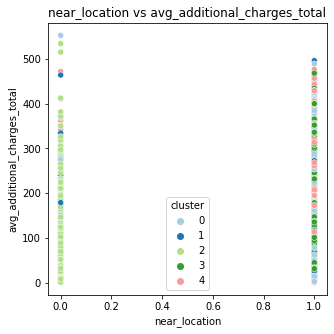

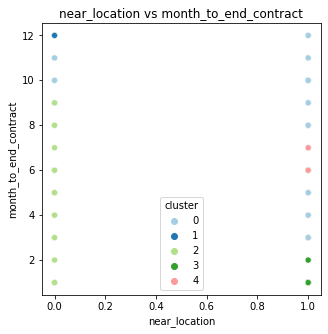

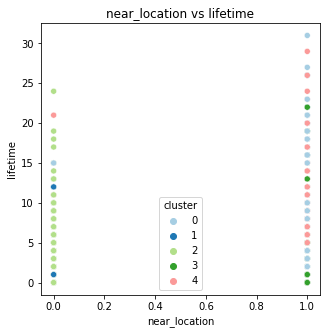

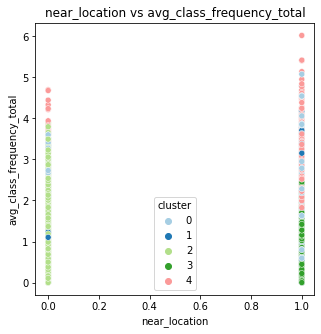

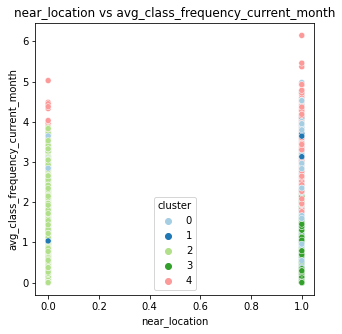

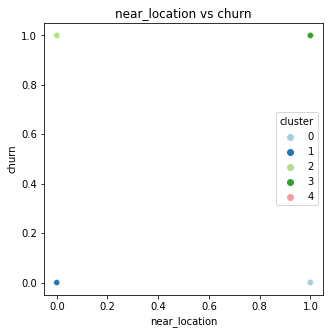

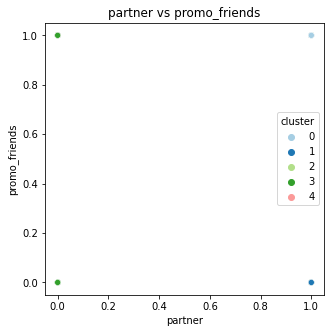

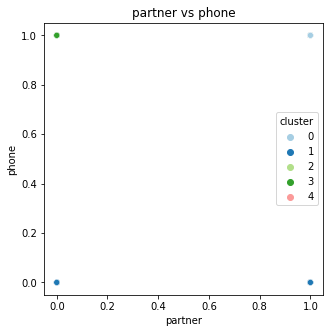

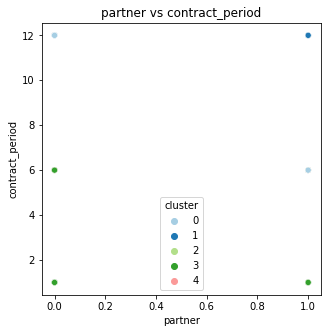

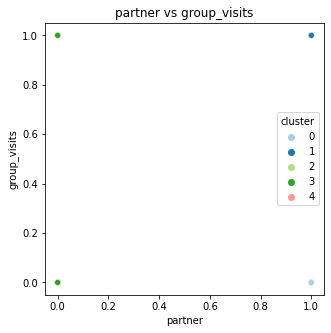

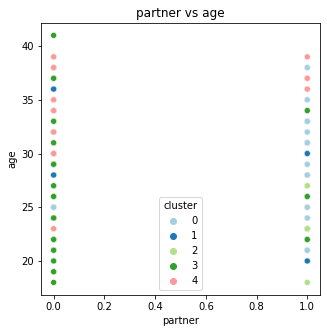

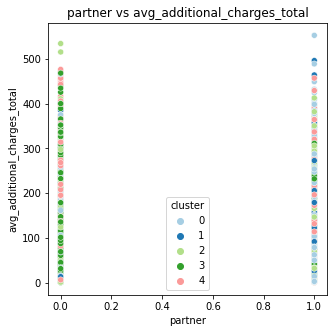

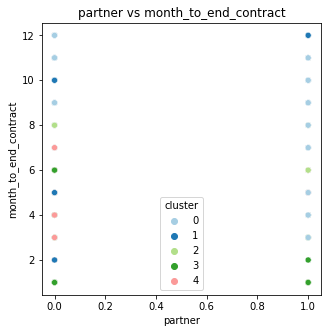

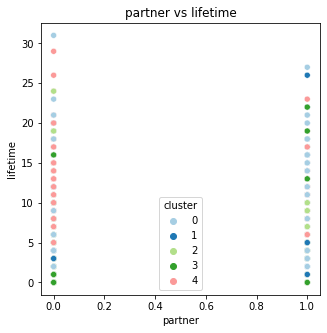

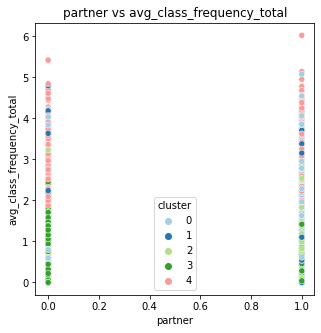

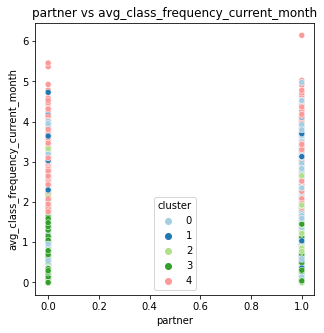

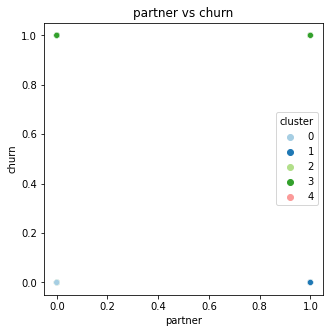

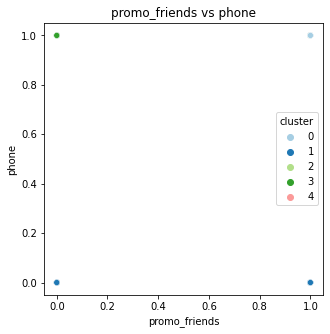

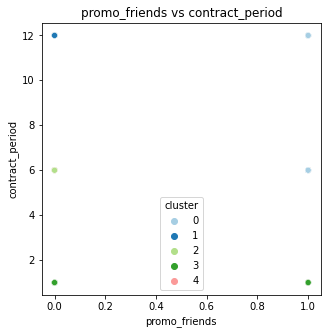

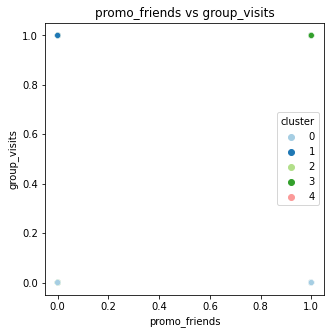

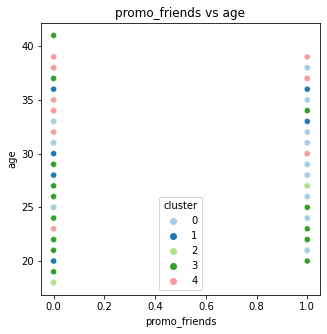

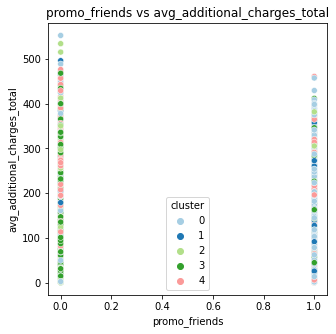

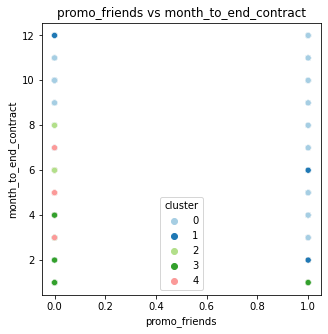

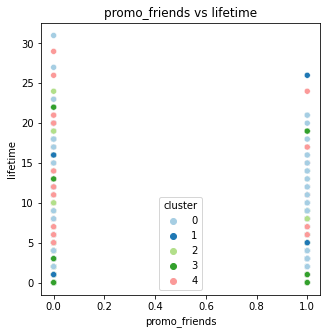

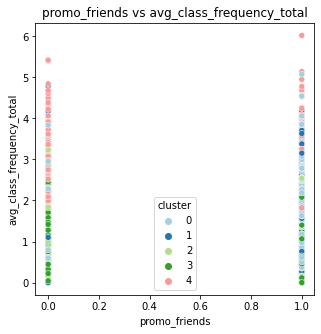

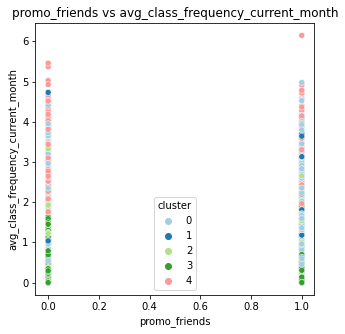

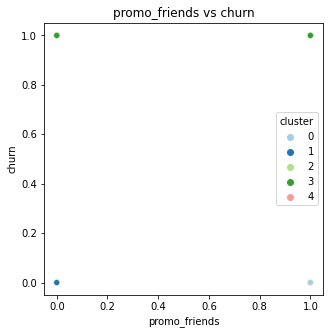

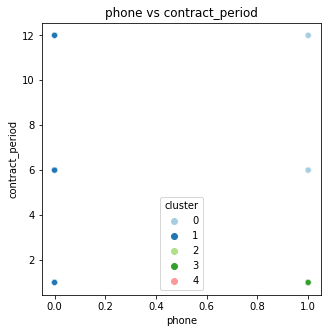

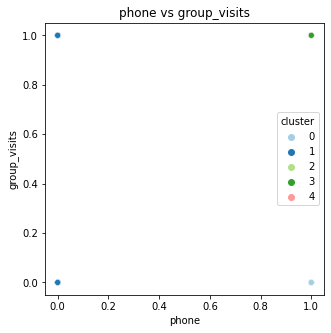

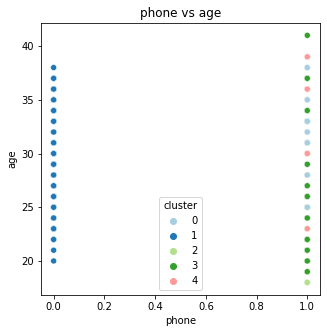

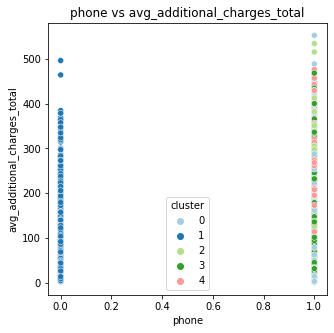

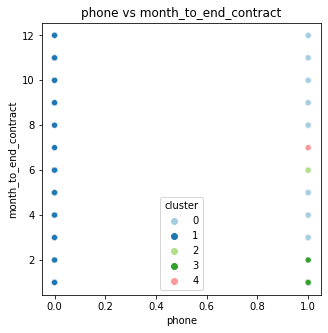

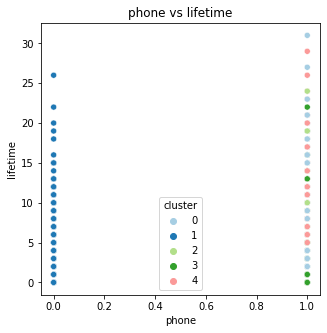

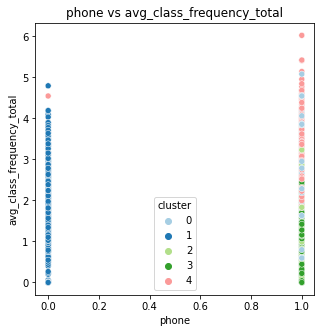

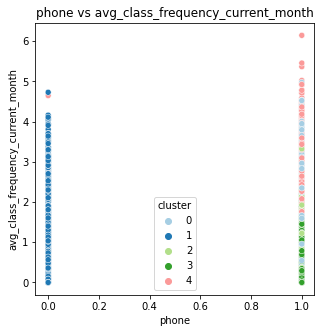

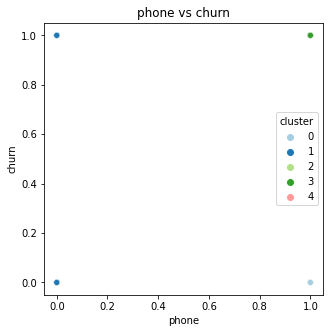

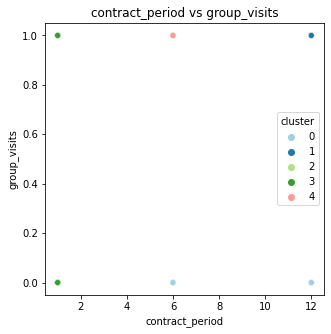

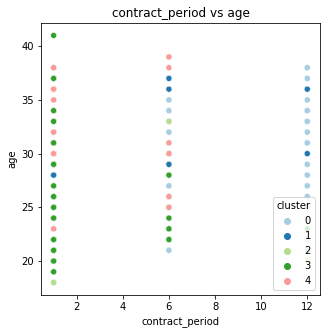

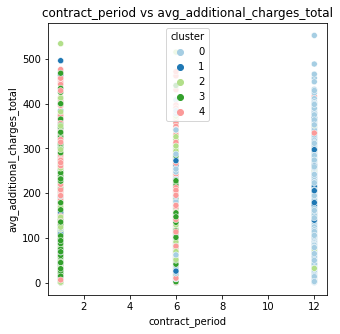

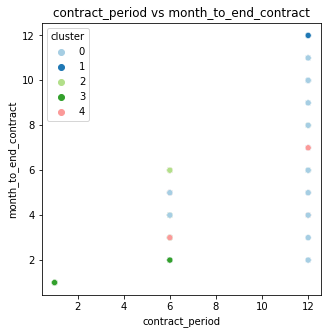

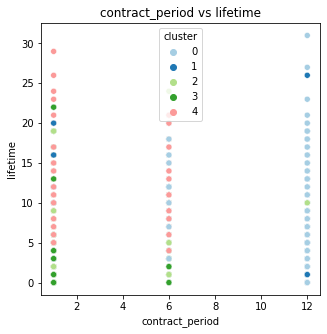

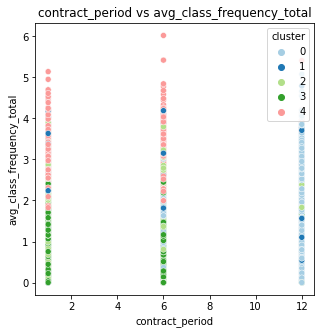

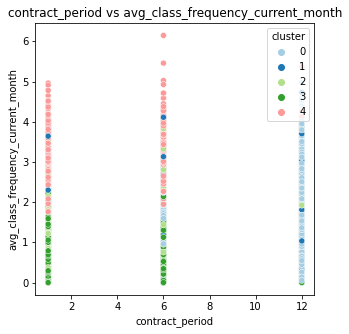

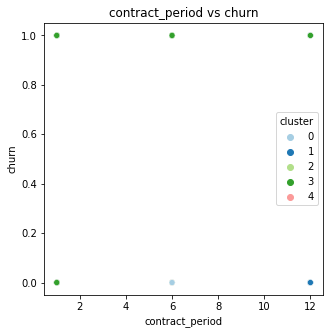

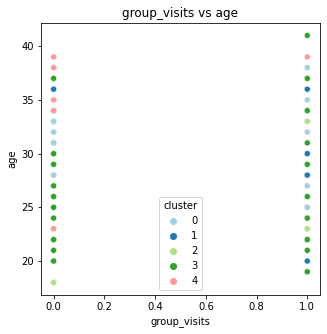

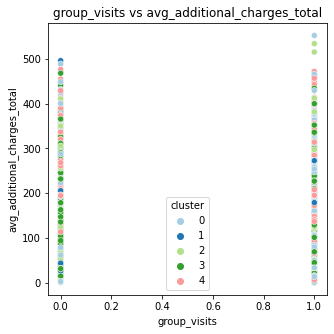

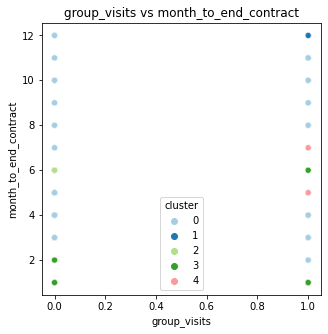

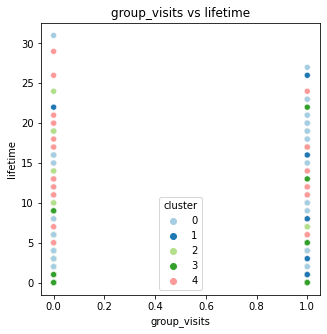

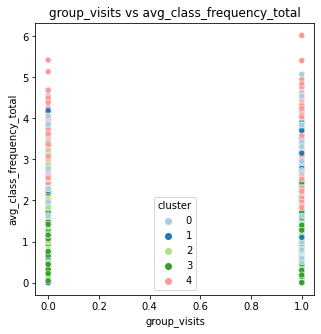

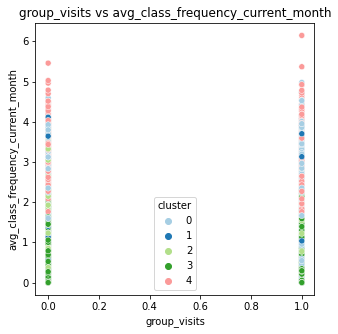

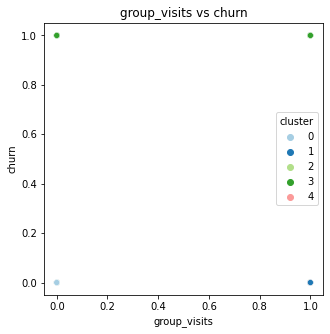

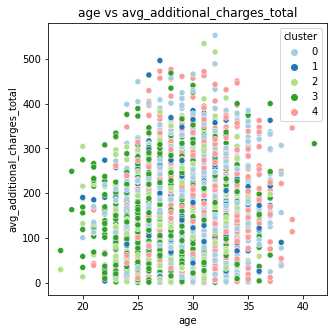

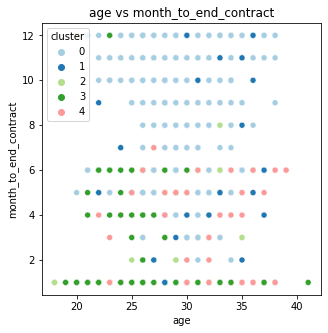

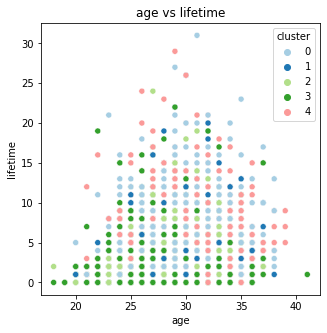

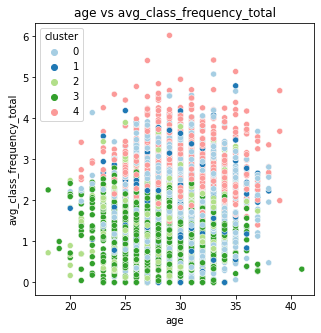

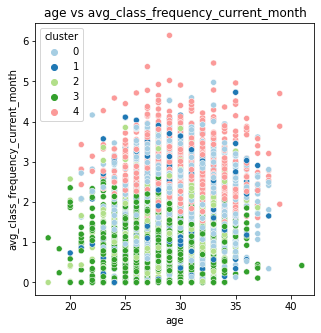

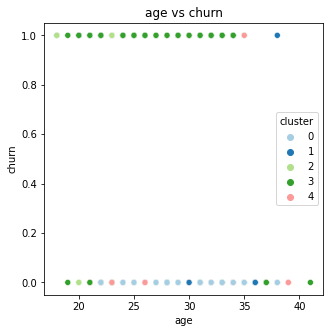

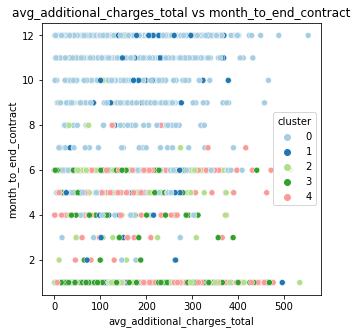

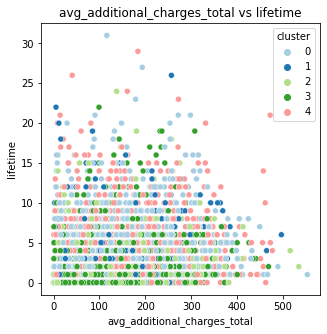

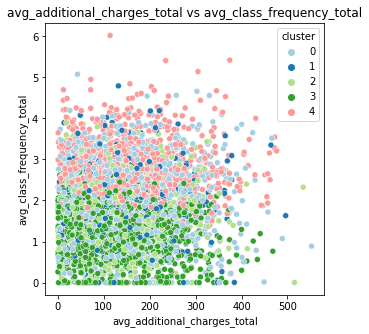

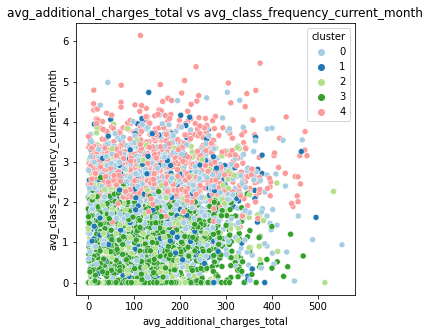

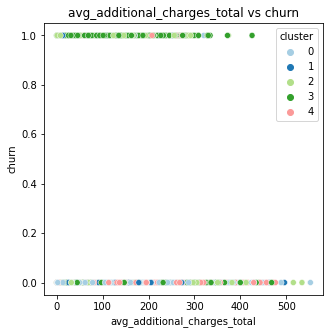

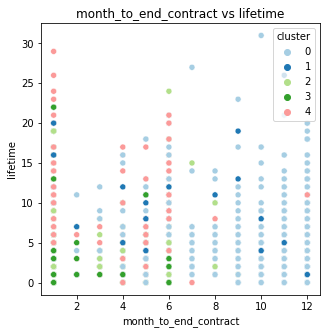

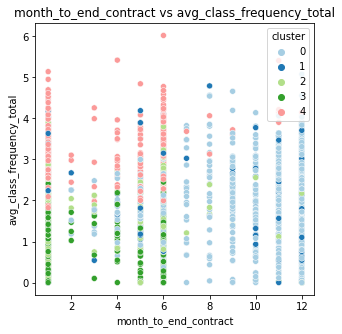

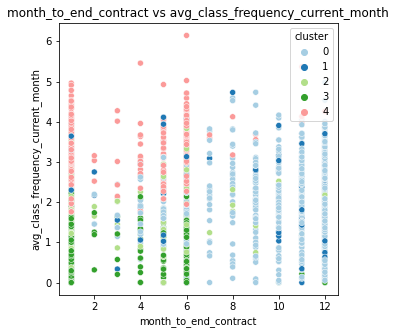

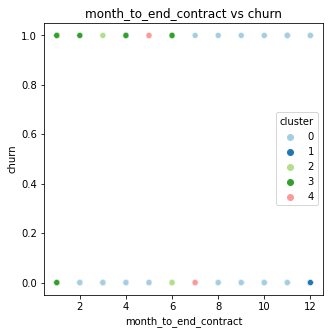

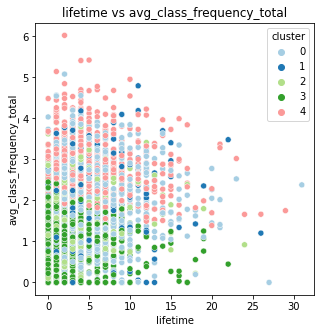

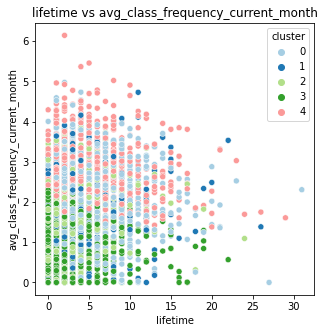

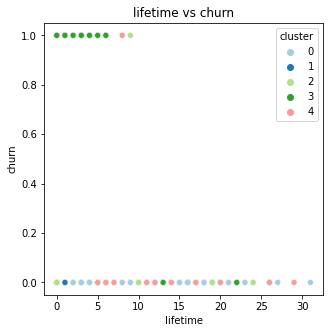

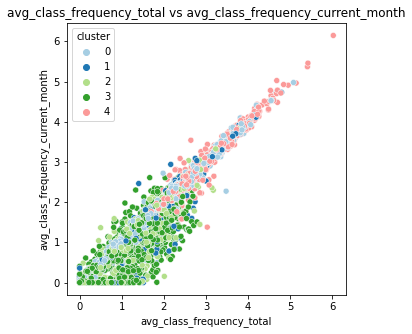

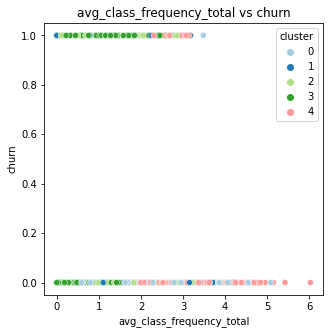

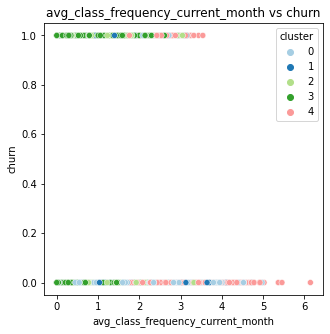

In [20]:
# создадим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster')

- Построим гистограммы и таблицу распределения признаков с учетом кластеров

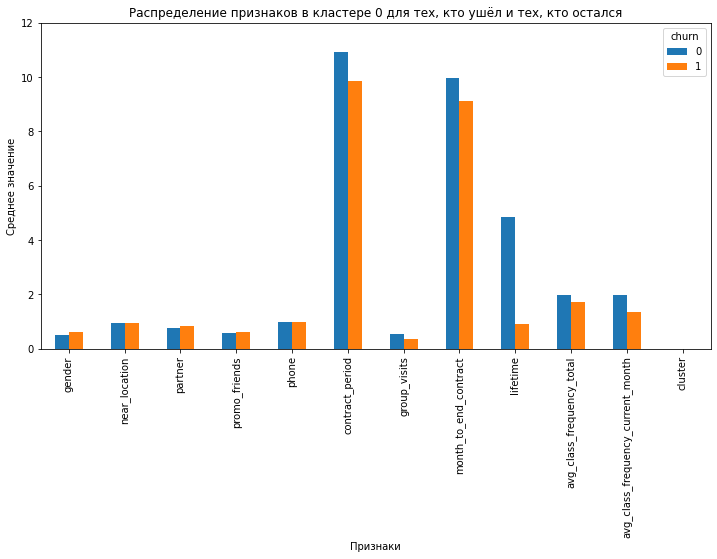

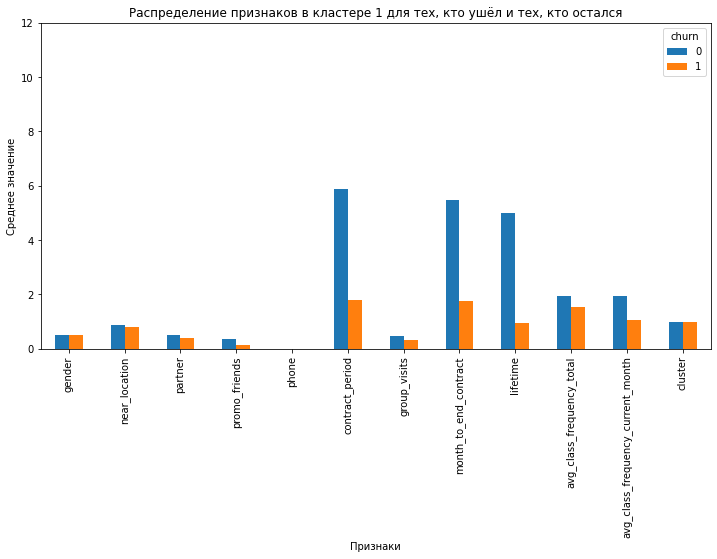

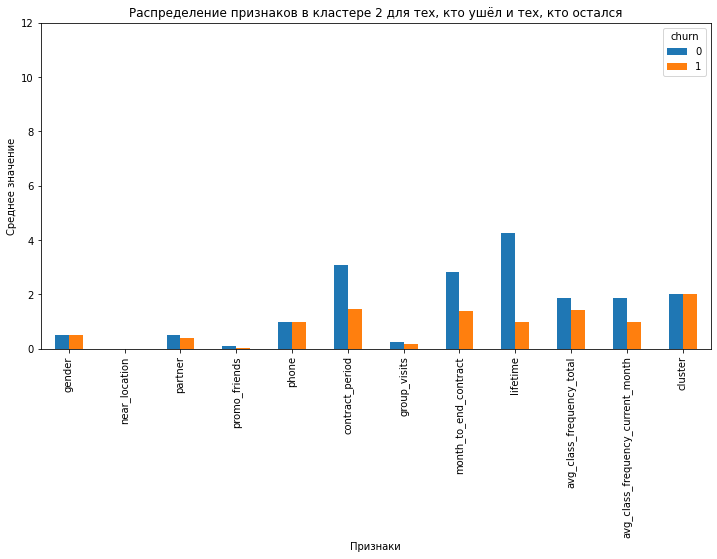

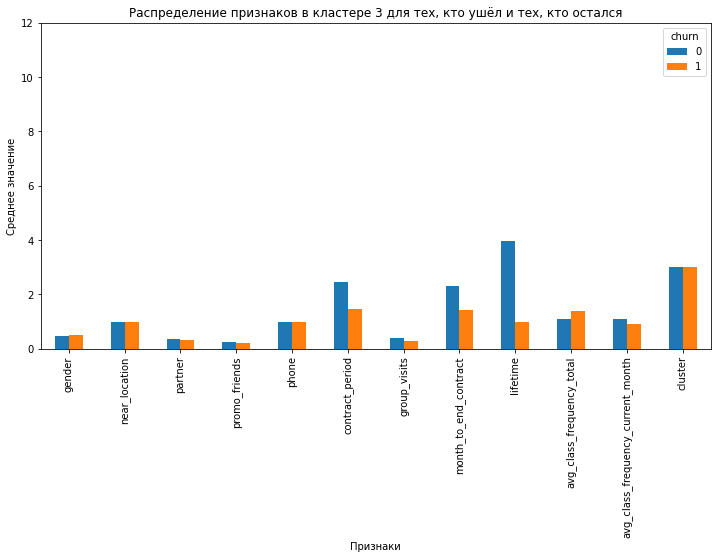

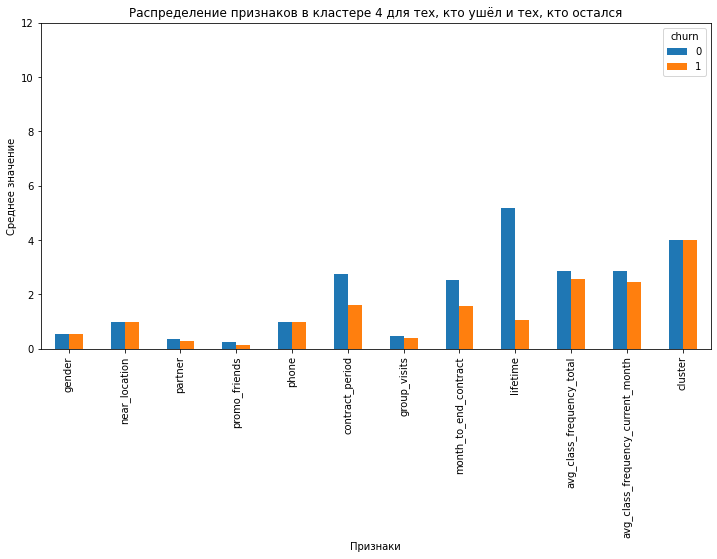

In [21]:
# создадим цикл для построения гистограмм по каждому кластеру без столбцов 'age'и'avg_additional_charges_total'

for i in range(5):
    claster_data = data.drop(['age','avg_additional_charges_total'], axis=1).query('cluster == @i').groupby('churn').mean().transpose()
    claster_data.plot(kind='bar',figsize=(12, 6), ylim=(0,12))
    plt.title(f'Распределение признаков в кластере {i} для тех, кто ушёл и тех, кто остался')
    plt.xlabel('Признаки')
    plt.ylabel('Среднее значение');

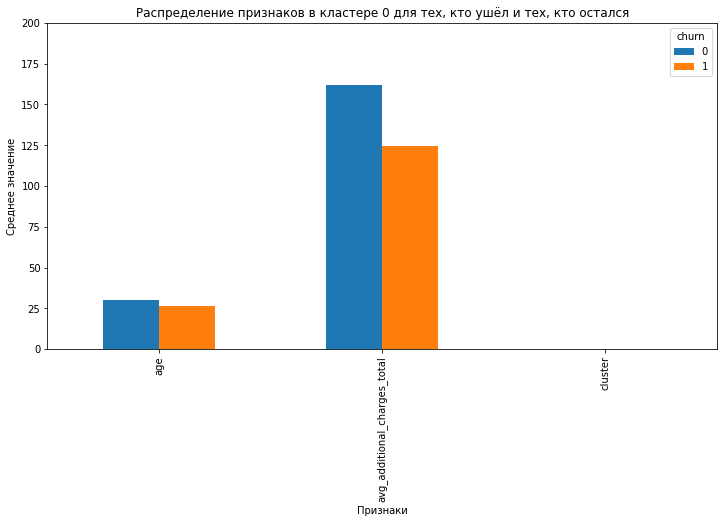

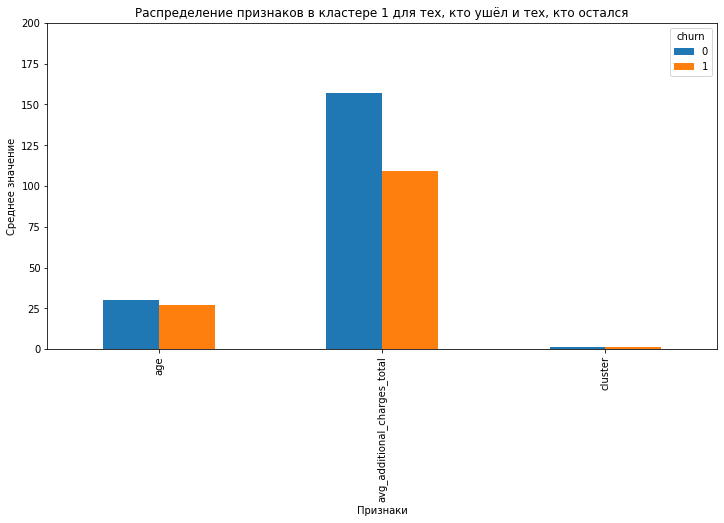

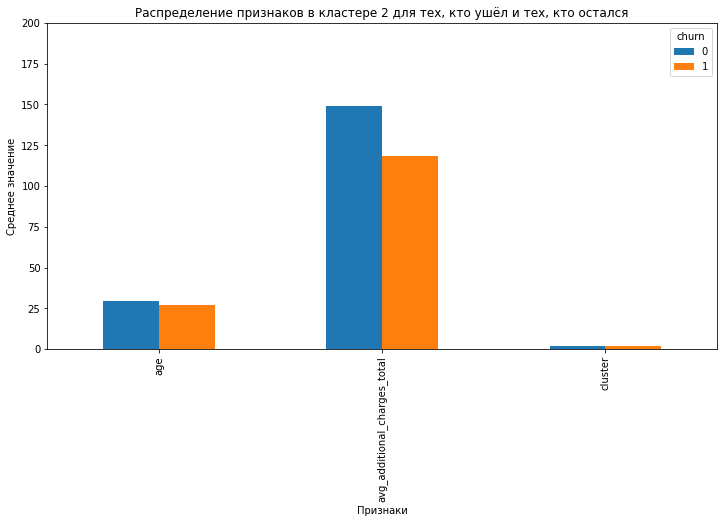

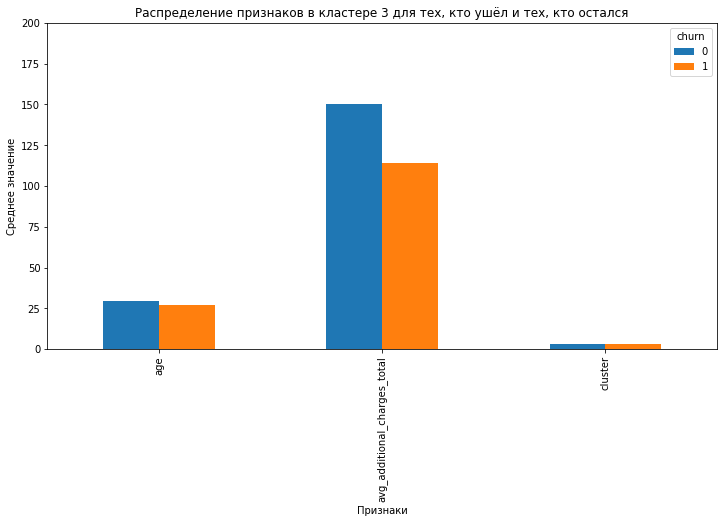

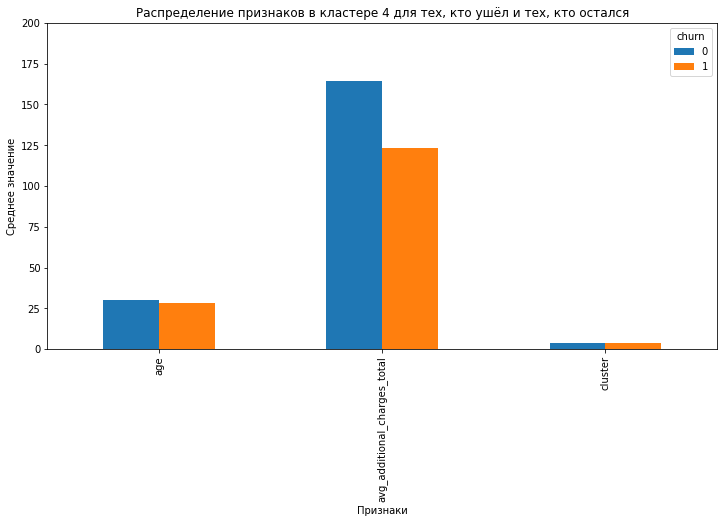

In [22]:
# создадим цикл для построения гистограмм по каждому кластеру только по столбцам 'age'и'avg_additional_charges_total'

for i in range(5):
    claster_data_new = data[['age','avg_additional_charges_total','cluster','churn']].query('cluster == @i').groupby('churn').mean().transpose()
    claster_data_new.plot(kind='bar',figsize=(12, 6), ylim=(0,200))
    plt.title(f'Распределение признаков в кластере {i} для тех, кто ушёл и тех, кто остался')
    plt.xlabel('Признаки')
    plt.ylabel('Среднее значение');

In [23]:
claster_data = data.groupby(['cluster', 'churn']).mean()
claster_data

gender  near_location   partner  promo_friends    phone  \
cluster churn                                                              
0       0      0.500000       0.959267  0.782077       0.573320  1.00000   
        1      0.607143       0.964286  0.821429       0.607143  1.00000   
1       0      0.521277       0.886525  0.500000       0.361702  0.00000   
        1      0.524272       0.796117  0.388350       0.155340  0.00000   
2       0      0.491103       0.000000  0.523132       0.110320  1.00000   
        1      0.500000       0.000000  0.388393       0.040179  1.00000   
3       0      0.466558       1.000000  0.378467       0.256117  1.00000   
        1      0.503852       1.000000  0.323575       0.224961  1.00000   
4       0      0.559539       0.974392  0.361076       0.238156  0.99872   
        1      0.561404       1.000000  0.298246       0.122807  1.00000   

               contract_period  group_visits        age  \
cluster churn                                             
0       0            10.918534      0.547862  30.076375   
        1             9.857143      0.357143  26.678571   
1       0             5.879433      0.460993  30.088652   
        1             1.796117      0.330097  27.145631   
2       0             3.067616      0.259786  29.669039   
        1             1.455357      0.160714  26.982143   
3       0             2.453507      0.406199  29.533442   
        1             1.471495      0.280431  26.878274   
4       0             2.746479      0.478873  30.268886   
        1             1.614035      0.403509  28.157895   

               avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster churn                                                                  
0       0                        161.794603               9.978615  4.845214   
        1                        124.511659               9.107143  0.928571   
1       0                        156.755592               5.468085  5.010638   
        1                        108.918677               1.757282  0.951456   
2       0                        149.149338               2.832740  4.256228   
        1                        118.281581               1.401786  0.995536   
3       0                        150.465296               2.313214  3.973899   
        1                        113.824339               1.425270  0.992296   
4       0                        164.453763               2.524968  5.179257   
        1                        123.349744               1.561404  1.052632   

               avg_class_frequency_total  avg_class_frequency_current_month  
cluster churn                                                                
0       0                       1.989601                           1.992325  
        1                       1.717399                           1.359790  
1       0                       1.958705                           1.957864  
        1                       1.541987                           1.055188  
2       0                       1.858190                           1.862332  
        1                       1.412416                           0.994344  
3       0                       1.109487                           1.108158  
        1                       1.378118                           0.923088  
4       0                       2.871574                           2.879319  
        1                       2.583825                           2.450654

- Посчитаем долю оттока для каждого кластера

In [24]:
# создадим сводную таблицу по кол-ву ушедших и оставшихся
cluster_data = data.pivot_table(index=['cluster'], columns='churn', values='gender', aggfunc='count')

# создадим новый столбец percent, в который запишем процент оттока для каждоко кластера
cluster_data['percent'] =cluster_data[1] / (cluster_data[1] + cluster_data[0]) * 100

#округлим значения до двух знаков после запятой
cluster_data.round(2)


churn,0,1,percent
cluster,,,
0,982,28,2.77
1,282,103,26.75
2,281,224,44.36
3,613,649,51.43
4,781,57,6.80


### Вывод:  

Основываясь на дендрограмме, можно разделить клиентов на 5 кластеров.  
С помощью алгоритма K-Means разделили клиентов на 5 кластеров.  

На основании средних значений признаков по каждому кластеру можно сделать выводы о том, что самый большой процент оттока в 4 группе - 51%. Для этой группы характерно: короткий абонимент, в среднем на 2 месяца и посещение фитнес-клуба 1 раз в неделю.

Самый большой процент оставшихся в группе 1. Для них характерно: близость фитнес-клуба к дому или работе, 78% из них являются сотрудниками компаний-партнеров, в среднем они купили абонимент на 11 месяцев и почти 60% использовали промокод от знакомого, число посещений в неделю равно 2.    

На графиках видно, что некоторые признаки кластеров не пересекаются друг с другом. Остальные же подтверждают выводы сделанные на основании средних значений.  

Во всех кластерах, те кто остался чуть старше и тратят, примерно, на треть больше на дополнительные услуги.

## Итоги исследования  



Прежде, чем исследовать данные, мы ознакомились с ними, проверили их корректность, привели к единому стилю написания названия столбцов.  

Исследуя данные, определили что:  

Для всех посетителей характерно:  
- 85% живут или работают в районе рядом с фитнес-клубом  
- 49% являются сотрудниками компаний-партнеров  
- 31% использовали промокод от знакомого  

Для тех, кто продолжил заниматься в сравнении с теми, кто ушел, характерно:  
- на 10% больше тех, кто живет или работает рядом с фитнес-центром  
- почти 54% являются сотрудниками компаний-партнеров, против 36%  
- в два раза больше посетителей воспользовались промокодом от знакомого  
- длительность абонимента в 3 раза больше, в среднем около 6 мес  
- в 2 раза чаще посещают групповые занятия  
 
С помощью матрицы расстояний определили, что всех посетителей можно разделить на 5 кластеров в зависимости от признаков.  

Алгоритмом K-Means поделили клиентов на 5 кластеров и посчитали среднее значение для каждого признака.  
Определили, что:  
- самый большой отток клиентов - 51% в группе, где клиенты покупали короткий абонимент, в среднем на 2 месяца, и посещали фитнес-клуб 1 раз в неделю
- небольшой отток в группах, где фитнес-клуб находится близко к дому или работе клиента, клиенты в основной своей массе являются сотрудниками компаний-партнеров, они покупает длительный абонимент, в среднем на 11 месяцев, и посещают фитнес-клуб 2 раза в неделю   

**Рекомендации:**  

- увеличивать кол-во компаний-партнеров, чтобы предлагать услуги и промоакции большему кол-ву сотрудников  
- проводить активные рекламные акции в районе, в котором находится фитнес-клуб  
- использовать промоакции и скидки на покупку абонементов от 6 месяцев  
- стимулировать увеличение кол-ва посещений в неделю дополнительными услугами